In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics, preprocessing
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Taking the processed.db file

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [3]:
write_db = 'D:\Applied AI Course\Case studies\Stack Overflow tag predictor/Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed LIMIT 100000""", conn_r)
conn_r.commit()
conn_r.close()

In [4]:
preprocessed_data.head()

,question,tags
0,chang cpu soni vaio pcg grx tri everywher find...,cpu motherboard sony-vaio replacement disassembly
1,display size grayscal qimag qt abl display ima...,c++ qt qt4
2,datagrid selecteditem set back null eventtocom...,mvvm silverlight-4.0
3,filter string collect base listview item resol...,c# winforms string listview collections
4,disabl home button without use type keyguard c...,android android-layout android-manifest androi...


In [5]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


# ML models

In [6]:
#converting string tags to multilabel outputs
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true', ngram_range=(1,4))
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

# selecting 500 tags

In [7]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [8]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

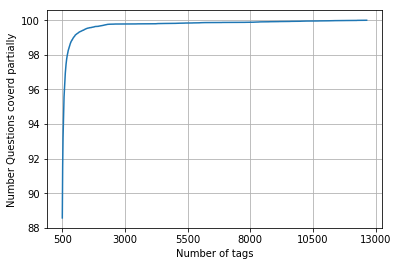

with  5500 tags we are covering  98.311 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [10]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 1689 out of  100000


In [11]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 243490
number of tags taken : 5500 ( 2.258819664051912 %)


# 15% tags are taken which cover 99% questions

In [12]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [13]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 5500)
Number of data points in test data : (20000, 5500)


# Featurizing data

In [14]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:39.495735


In [15]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 6286) Y : (80000, 5500)
Dimensions of test data X: (20000, 6286) Y: (20000, 5500)


# Applying Logisitc Regression with OneVsRestClassifier

In [16]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.06975
macro f1 score : 0.05280022849918097
micro f1 scoore : 0.3114298605998717
hamming loss : 0.0005271818181818181
Precision recall report :
              precision    recall  f1-score   support

          0       0.66      0.23      0.35      1587
          1       0.77      0.42      0.54      1425
          2       0.85      0.57      0.68      1415
          3       0.72      0.42      0.53      1208
          4       0.92      0.74      0.82      1129
          5       0.84      0.64      0.73      1012
          6       0.64      0.33      0.44       678
          7       0.88      0.63      0.73       596
          8       0.68      0.38      0.49       642
          9       0.79      0.44      0.56       591
         10       0.84      0.61      0.71       609
         11       0.50      0.17      0.26       574
         12       0.58      0.10      0.17       537
         13       0.55      0.26      0.36       483
         14       0.80      0.53      0.64     

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Feature engineering using RandomSearch Cross validation

In [18]:
#OneVsRestClassifier(SGDClassifier(loss='log'))
#params we need to try on classifier
param_dist = {#'penalty':['l1','l2','elasticnet'],
             'estimator__alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
gsv_bow = RandomizedSearchCV(OneVsRestClassifier(SGDClassifier(loss='log')),param_dist,cv=3,verbose=1, n_jobs=-1)
gsv_bow.fit(x_train_multilabel,y_train)
print("Best HyperParameter: ",gsv_bow.best_params_)
print("Best Accuracy: %.2f%%"%(gsv_bow.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 121.8min finished


Best HyperParameter:  {'estimator__alpha': 1e-05}
Best Accuracy: 6.36%


# LogisticRegression with features from RandomizedSearchCV

In [19]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.0692
macro f1 score : 0.05301230886358046
micro f1 scoore : 0.31203284056664216
hamming loss : 0.0005271454545454546
Precision recall report :
              precision    recall  f1-score   support

          0       0.65      0.25      0.36      1587
          1       0.77      0.42      0.54      1425
          2       0.85      0.58      0.69      1415
          3       0.72      0.43      0.54      1208
          4       0.92      0.74      0.82      1129
          5       0.85      0.64      0.73      1012
          6       0.68      0.31      0.43       678
          7       0.88      0.63      0.74       596
          8       0.69      0.38      0.49       642
          9       0.77      0.45      0.57       591
         10       0.83      0.61      0.70       609
         11       0.51      0.18      0.26       574
         12       0.56      0.10      0.17       537
         13       0.55      0.25      0.34       483
         14       0.81      0.54      0.65     

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# OneVsRest using LinearSVM(SGD classifier with loss=hinge)

In [20]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.0766
macro f1 score : 0.03192890738074657
micro f1 scoore : 0.3008505709909215
hamming loss : 0.0005103727272727273
Precision recall report :
              precision    recall  f1-score   support

          0       0.68      0.20      0.31      1587
          1       0.78      0.42      0.55      1425
          2       0.85      0.61      0.71      1415
          3       0.75      0.44      0.55      1208
          4       0.93      0.78      0.85      1129
          5       0.85      0.66      0.75      1012
          6       0.71      0.29      0.42       678
          7       0.87      0.67      0.76       596
          8       0.72      0.38      0.49       642
          9       0.77      0.47      0.59       591
         10       0.85      0.63      0.72       609
         11       0.63      0.06      0.11       574
         12       0.25      0.00      0.00       537
         13       0.61      0.24      0.34       483
         14       0.76      0.57      0.65      

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
